# One hidden layer neural network

In [57]:
import numpy as np
from utils import plot_decision_boundary, load_extra_datasets, load_planar_dataset

import sklearn
import sklearn.datasets
import sklearn.linear_model

from test_cases import *

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 1
np.random.seed(SEED)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [2]:
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

dataset = "noisy_moons"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

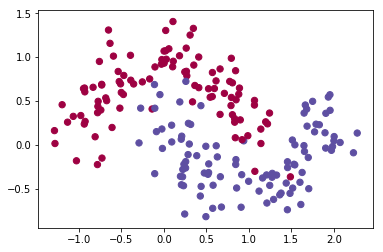

In [3]:
plt.scatter(X[0, :], X[1, :], c=Y.ravel(), s=40, cmap=plt.cm.Spectral);

In [4]:
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1]

print("X shape = {}".format(shape_X))
print("Y shape = {}".format(shape_Y))
print("Number of samples = {}".format(m))

X shape = (2, 200)
Y shape = (1, 200)
Number of samples = 200


## Logistic Regression

In [5]:
LR_model = sklearn.linear_model.LogisticRegressionCV()
LR_model.fit(X.T, Y.T.ravel())

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

Accuracy of logistic regression: [86.]


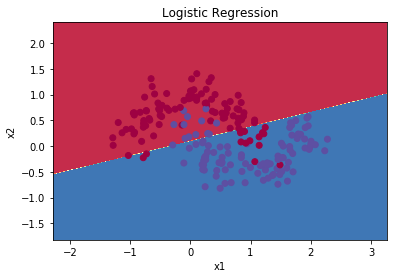

In [6]:
plot_decision_boundary(lambda x: LR_model.predict(x), X, Y.ravel())
plt.title("Logistic Regression")

predictions = LR_model.predict(X.T)

acc = (np.dot(Y, predictions) + np.dot(1 - Y, 1 - predictions)) / Y.size * 100
print("Accuracy of logistic regression: {}".format(acc))

## Neural Network model

$ z^{[1][i]} = W^{[1} x^{(i)} + b^{[1](i)} $

$ a^{[1](i)} = tanh(z^{[1](i)}) $

$ z^{[2][i]} = W^{[2} a^{[1](i)} + b^{[2](i)} $

$ \hat{y}^{(i)} = a^{[2](i)} = \sigma(z^{[2](i)})$

$ y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases} $

### Define the neural network structure

In [7]:
def layer_sizes(X, Y, h=4):
    """
    Arguments:
    X - Input that shape is (input size, number of samples)
    Y - Output that shape is (output size, number of samples)
    
    Returns:
    n_x - the size of the input layer
    n_h - the size of the hidden layer
    n_y - the size of the output layer
    """
    n_x = X.shape[0] # Size of input layer
    n_h = h # Size of hidden layer
    n_y = Y.shape[0] # Size of output layer
    return (n_x, n_h, n_y)

In [8]:
mock_X, mock_Y = test_case_layer_sizes()
n_x, n_h, n_y = layer_sizes(mock_X, mock_Y)
print("The size of the input layer is {}".format(n_x))
print("The size of the hidden layer is {}".format(n_h))
print("The size of the output layer is {}".format(n_y))

The size of the input layer is 5
The size of the hidden layer is 4
The size of the output layer is 2


### Initialize the model's parameters

In [9]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Arguments:
    n_x - Input size
    n_h - Hidden size
    n_y - Output size
    
    Returns:
    params - containing:
            W1 - first layer weights that shape is (n_h, n_x)
            b1 - first layer bias that shape is (n_h, 1)
            W2 - second layer weights that shape is (n_y, n_h)
            b2 - second layer bias that shape is (n_y, 1)
    """
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    params = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    return params

In [10]:
mock_n_x, mock_n_h, mock_n_y = test_case_initialize_parameters()
params = initialize_parameters(mock_n_x, mock_n_h, mock_n_y)
print("W1 = {}".format(params["W1"]))
print("b1 = {}".format(params["b1"]))
print("W2 = {}".format(params["W2"]))
print("b2 = {}".format(params["b2"]))

W1 = [[ 0.01144724  0.00901591]
 [ 0.00502494  0.00900856]
 [-0.00683728 -0.0012289 ]
 [-0.00935769 -0.00267888]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[ 0.00530355 -0.00691661 -0.00396754 -0.00687173]]
b2 = [[0.]]


### Forward propagation

$ z^{[1][i]} = W^{[1} x^{(i)} + b^{[1](i)} $

$ a^{[1](i)} = tanh(z^{[1](i)}) $

$ z^{[2][i]} = W^{[2} a^{[1](i)} + b^{[2](i)} $

$ a^{[2](i)} = \sigma(z^{[2](i)})$

In [11]:
def sigmoid(x):
    """
    Arguments
    x - A scalar or numpy of any size
    
    Returns
    s - sigmoid(x)
    """
    s = 1 / (1 + np.exp(-x))
    return s

In [12]:
def forward_propagation(X, params):
    """
    Arguments
    X - input data that shape is (n_x, m)
    params - parameters containing output of initialize_parameters function
    
    Returns
    cache - a dictionary containing "Z1", "A1", "Z2", and "A2"
    """
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    cache = {
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2
    }
    return cache

In [16]:
mock_X, mock_params = test_case_forward_progagation()
cache = forward_propagation(mock_X, mock_params)

print("Z1 = {}\nA1 = {}\nZ2 = {}\nA2 = {}".format(np.mean(cache["Z1"]), np.mean(cache["A1"]), np.mean(cache["Z2"]), np.mean(cache["A2"])))

Z1 = 0.5975827914852041
A1 = -0.06055495886873228
Z2 = -0.3141465045401778
A2 = 0.43094873666252836


### Cost function

$ J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} $

In [55]:
def compute_cost(A2, Y, params):
    """
    Arguments
    A2 - The sigmoid output of the second layer's activation that shape is (1, number of samples)
    Y - The ground truth that shape is (1, number of samples)
    params - The parameters containing W1, b1, W2, b2
    
    Returns
    cost - Cross-entropy
    """
    m = Y.shape[1]
    log_probs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), (1 - A2))
    cost = -np.sum(log_probs) / float(m)
    cost = np.squeeze(cost)
    return cost

In [54]:
mock_A2, mock_Y, mock_params = test_case_compute_cost()
cost = compute_cost(mock_A2, mock_Y, mock_params)
print("cost = {}".format(cost))

cost = 0.4071906236773964


In [62]:
def backward_progagation(params, cache, X, Y):
    
    m = X.shape[1]
    
    W1 = params["W1"]
    W2 = params["W2"]
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    dZ2 = A2 - Y
    dW2 = (1. / m) * np.dot(dZ2, A1.T)
    db2 = (1. / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = (1. / m) * np.dot(dZ1, X.T)
    db1 = (1.0 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
            "db1": db1,
            "dW2": dW2,
            "db2": db2}
    return grads

In [64]:
mock_params, mock_cache, mock_X, mock_Y = test_case_backward_progagation()
grads = backward_progagation(mock_params, mock_cache, mock_X, mock_Y)

print("dW1 = {}\ndb1 = {}\ndW2 = {}\ndb2 = {}".format(grads["dW1"], grads["db1"], grads["dW2"], grads["db2"]))

dW1 = [[-0.43412832  0.44283189]
 [-0.03252708  0.04168612]
 [ 0.1356952   0.31504721]
 [-0.31036889  0.27806308]]
db1 = [[-0.47016983]
 [-0.04004728]
 [ 0.27166502]
 [-0.49943179]]
dW2 = [[-0.28901381  0.65601576 -0.05913122  0.13099899]]
db2 = [[-0.63861922]]


In [66]:
def update_parameters(params, grads, learning_rate=1.2):
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    params = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    return params